In [394]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
import matplotlib.patches as patches
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
torch.cuda.set_device(2)
print (torch.cuda.current_device())

2


In [4]:
def Image_Processing(img_path, crop_size=224):
    img = Image.open(img_path).convert('RGB').resize((256, 256),Image.ANTIALIAS) #open and resize
    #crop and normalize
    transform_sequence = transforms.Compose([
                                             #transforms.ToPILImage(), #if not PILImage
                                             transforms.CenterCrop(crop_size),
                                             transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
                                             #transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                                            ])
    img = transform_sequence(img).numpy() #tensor to numpy
    return img

#preparing the trainset and  testset
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
trN, trI, trY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            trN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            trY.append(np.array(image_label))
            #img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX) #normalization
            img = Image_Processing(os.path.join(img_path, image_name))
            trI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(trN),78468))
        sys.stdout.flush()
trI = np.array(trI)
trY = np.array(trY)   
print('The length of trainset is %d'%len(trN))
        
valN, valI, valY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            valN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            valY.append(np.array(image_label))
            #img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX) #normalization
            img = Image_Processing(os.path.join(img_path, image_name))
            valI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(valN),11219))
        sys.stdout.flush()
valI = np.array(valI)
valY = np.array(valY) 
print('The length of validset is %d'%len(valN))

teN, teI, teY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            teN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            teY.append(np.array(image_label))
            #img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX) #normalization
            img = Image_Processing(os.path.join(img_path, image_name))                    
            teI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(teN),22433))
        sys.stdout.flush()
teI = np.array(teI)
teY = np.array(teY)    
print('The length of testset is %d'%len(teN))

78468 / 78468 The length of trainset is 78468
11219 / 11219 The length of validset is 11219
22433 / 22433 The length of testset is 22433


In [5]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

In [7]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 30 #'Batch Size': 32
for epoch in range(50):#'Max Epoch': 1000
    num_batches = len(trY) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch)#permute the dims of matrix， .permute(0, 3, 1, 2)
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch)#forword， .permute(0, 3, 1, 2)
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

 374 / 374 : validation loss = 0.151127Eopch:     1 val_loss = 0.179529
 374 / 374 : validation loss = 0.143716Eopch:     2 val_loss = 0.170689
 374 / 374 : validation loss = 0.143334Eopch:     3 val_loss = 0.171043
 374 / 374 : validation loss = 0.150633Eopch:     4 val_loss = 0.172481
 374 / 374 : validation loss = 0.149011Eopch:     5 val_loss = 0.172828
 374 / 374 : validation loss = 0.144161Eopch:     6 val_loss = 0.167542
 374 / 374 : validation loss = 0.143853Eopch:     7 val_loss = 0.166715
 374 / 374 : validation loss = 0.141509Eopch:     8 val_loss = 0.165363
 374 / 374 : validation loss = 0.141106Eopch:     9 val_loss = 0.164300
 374 / 374 : validation loss = 0.140005Eopch:    10 val_loss = 0.162717
 374 / 374 : validation loss = 0.138711Eopch:    11 val_loss = 0.162790
 374 / 374 : validation loss = 0.135128Eopch:    12 val_loss = 0.162438
 374 / 374 : validation loss = 0.138882Eopch:    13 val_loss = 0.161626
 374 / 374 : validation loss = 0.137715Eopch:    14 val_loss = 0

In [8]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 747 / 748 The average AUROC is 0.7747
The AUROC of Atelectasis is 0.7751
The AUROC of Cardiomegaly is 0.8822
The AUROC of Effusion is 0.8557
The AUROC of Infiltration is 0.6778
The AUROC of Mass is 0.7451
The AUROC of Nodule is 0.6748
The AUROC of Pneumonia is 0.7079
The AUROC of Pneumothorax is 0.7925
The AUROC of Consolidation is 0.7825
The AUROC of Edema is 0.8641
The AUROC of Emphysema is 0.7748
The AUROC of Fibrosis is 0.7419
The AUROC of Pleural_Thickening is 0.7258
The AUROC of Hernia is 0.8451


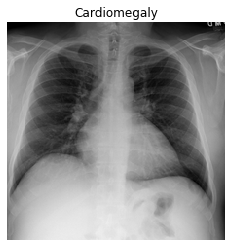

In [119]:
#show raw image after resizing and cropping   
raw_img = Image.open(os.path.join(img_path, teN[4])).convert('RGB').resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
img_label = np.array(CLASS_NAMES)[np.where(teY[4]==1)[0]]
plt.imshow(raw_img)
#plt.imshow(raw_img, cmap='gray')
plt.title(img_label[0]) #show labels
plt.axis('off') 
plt.show()  

0.0962 -> Cardiomegaly
0.0802 -> Infiltration
0.0740 -> Atelectasis
0.0714 -> Effusion
0.0694 -> Nodule
0.0683 -> Consolidation
0.0680 -> Edema
0.0679 -> Pneumonia
0.0679 -> Pleural_Thickening
0.0677 -> Fibrosis
0.0674 -> Pneumothorax
0.0674 -> Mass
0.0672 -> Emphysema
0.0670 -> Hernia


(-0.5, 223.5, 223.5, -0.5)

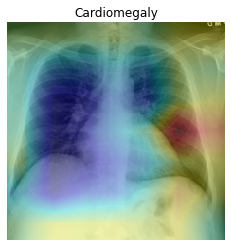

In [120]:
network_model = best_net.dense_net_121.features
network_model.eval()  # set network as evaluation model
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(teI[4]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    var_output = network_model(input_img)#forword
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
    
#get the last and second last weights, like [classes, hiden nodes]
#weights = list(network_model.parameters())[-2]# select the last convolution layers' weights as weights of CAM
# start generating heat map
#heat_map = None
#for i in range(0, len(weights)):
#    tmp_map = var_output[0, i, :, :]
#    if i == 0:
#       heat_map = weights[i] * tmp_map
#    else:
#        heat_map += weights[i] * tmp_map
# normalizing the output
#def normalize_output(img):
#    img = img - img.min()
#    img = img / img.max()
#    return img
#heat_map = heat_map.cpu().data.numpy()# convert cuda tensor to cpu numpy nd-array
#heat_map = normalize_output(heat_map)
#heat_map = cv2.resize(heat_map, (224, 224))
        
cls_weights = list(best_net.parameters())
weight_softmax = np.squeeze(cls_weights[-2].data.cpu().numpy()) 
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
    
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape

    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
    #cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img
#get the class activation maps
cam_img = returnCAM(var_output.cpu().data.numpy(), weight_softmax, idx[0].item())
heat_map = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(img_label[0]) #show labels
plt.axis('off')

In [302]:
class GradCAM(object):
    """
    1: gradients update when input
    2: backpropatation by the high scores of class
    """
 
    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()
 
    def _get_features_hook(self, module, input, output):
        self.feature = output
        #print("feature shape:{}".format(output.size()))
 
    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple,length = 1
        :return:
        """
        self.gradient = output_grad[0]
 
    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))
 
    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()
 
    def __call__(self, inputs, index=None):
        """
        :param inputs: [1,3,H,W]
        :param index: class id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()
 
        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))  # [C]
 
        feature = self.feature[0].cpu().data.numpy()  # [C,H,W]
 
        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        cam = np.maximum(cam, 0)  # ReLU

        # nomalization
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 256*256
        cam = cv2.resize(cam, (224, 224)) #resize
        
        return cam
 
 
class GradCamPlusPlus(GradCAM):
    def __init__(self, net, layer_name):
        super(GradCamPlusPlus, self).__init__(net, layer_name)
 
    def __call__(self, inputs, index=None):
        """
        :param inputs: [1,3,H,W]
        :param index: class id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()
 
        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        gradient = np.maximum(gradient, 0.)  # ReLU
        indicate = np.where(gradient > 0, 1., 0.)  # 示性函数
        norm_factor = np.sum(gradient, axis=(1, 2))  # [C]归一化
        for i in range(len(norm_factor)):
            norm_factor[i] = 1. / norm_factor[i] if norm_factor[i] > 0. else 0.  # 避免除零
        alpha = indicate * norm_factor[:, np.newaxis, np.newaxis]  # [C,H,W]
 
        weight = np.sum(gradient * alpha, axis=(1, 2))  # [C]  alpha*ReLU(gradient)
 
        feature = self.feature[0].cpu().data.numpy()  # [C,H,W]
 
        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        # cam = np.maximum(cam, 0)  # ReLU
 
        # nomalization
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize 
        cam = cv2.resize(cam, (224, 224))
        return cam
    
class GuidedBackPropagation(object):
 
    def __init__(self, net):
        self.net = net
        for (name, module) in self.net.named_modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(self.backward_hook)
                
        self.net.eval()
 
    @classmethod
    def backward_hook(cls, module, grad_in, grad_out):
        """
        :param module:
        :param grad_in: tuple,length=1
        :param grad_out: tuple,length=1
        :return: tuple(new_grad_in,)
        """
        return torch.clamp(grad_in[0], min=0.0),
 
    def __call__(self, inputs, index=None):
        """
        :param inputs: [1,3,H,W]
        :param index: class_id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
 
        target.backward()
 
        return inputs.grad[0]  # [3,H,W]

(-0.5, 223.5, 223.5, -0.5)

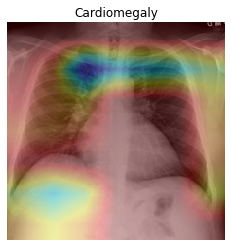

In [133]:
# Grad-CAM    
grad_cam = GradCAM(net=best_net, layer_name='dense_net_121.features.denseblock4.denselayer16.conv2')
mask = grad_cam(input_img)  # cam mask
grad_cam.remove_handlers()
heat_map = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(img_label[0]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

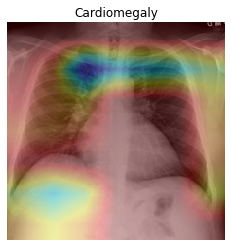

In [142]:
# Grad-CAM++
grad_cam_plus_plus = GradCamPlusPlus(net=best_net, layer_name='dense_net_121.features.denseblock4.denselayer16.conv2')
mask_plus_plus = grad_cam_plus_plus(input_img)  # cam mask
grad_cam_plus_plus.remove_handlers()
heat_map = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(img_label[0]) #show labels
plt.axis('off')

In [140]:
# GuidedBackPropagation
gbp = GuidedBackPropagation(best_net)
grad = gbp(input_img)
print(grad.shape)

torch.Size([3, 224, 224])


In [129]:
for name, layer in best_net.named_modules():
    #if isinstance(layer, nn.ReLU):
    print(name, layer)

 DenseNet121(
  (dense_net_121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [166]:
#process bounding box dataset
boxdata = pd.read_csv("/data/fjsdata/NIH-CXR/BBox_List_2017.csv" , sep=',')
boxdata = boxdata[['Image Index','Finding Label','Bbox [x', 'y', 'w', 'h]']]
print('Dataset statistic, records: %d, fields: %d' % (boxdata.shape[0], boxdata.shape[1]))
print(boxdata.columns.values.tolist())

CLASS_NAMES_Box = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltrate', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 

bbN, bbI, bbY, bBox = [],[],[],[]
for _, row in boxdata.iterrows():
    bbN.append(row['Image Index'])
    
    img = Image_Processing(os.path.join(img_path, row['Image Index']))
    bbI.append(img)
    
    labels = np.zeros(len(CLASS_NAMES_Box))
    labels[CLASS_NAMES_Box.index(row['Finding Label'])] = 1
    bbY.append(labels)
    
    bBox.append(np.array([row['Bbox [x'], row['y'], row['w'], row['h]']])) #xywh   

Dataset statistic, records: 984, fields: 6
['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]']


In [180]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(bbY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(bbY), (i+1)*batchSize])
        I_batch = torch.from_numpy(np.array(bbI)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(bbY)[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch)#forword，.permute(0, 3, 1, 2)
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in [0, 1, 2, 3, 4, 5, 6, 7]:
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES_Box[i], AUROCs[i]))

 32 / 33 The average AUROC is 0.7022
The AUROC of Atelectasis is 0.6803
The AUROC of Cardiomegaly is 0.9034
The AUROC of Effusion is 0.7460
The AUROC of Infiltrate is 0.6613
The AUROC of Mass is 0.6779
The AUROC of Nodule is 0.6386
The AUROC of Pneumonia is 0.5225
The AUROC of Pneumothorax is 0.7877


In [346]:
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[3]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
    
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)

0.0956 -> Atelectasis
0.0854 -> Effusion
0.0832 -> Infiltration
0.0724 -> Consolidation
0.0678 -> Edema
0.0678 -> Mass
0.0667 -> Emphysema
0.0664 -> Pleural_Thickening
0.0664 -> Pneumothorax
0.0663 -> Nodule
0.0661 -> Cardiomegaly
0.0657 -> Pneumonia
0.0651 -> Fibrosis
0.0650 -> Hernia


(-0.5, 1023.5, 1023.5, -0.5)

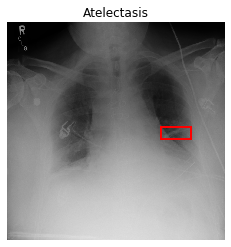

In [347]:
raw_img = Image.open(os.path.join(img_path, bbN[3])).convert('RGB')
raw_img= np.array(raw_img)

fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[3][0]), int(bBox[3][1]), int(bBox[3][2]), int(bBox[3][3])
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES)[np.where(bbY[0]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

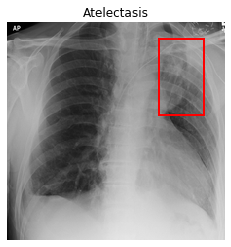

In [354]:
raw_img = Image.open(os.path.join(img_path, bbN[1])).convert('RGB')
width, height = raw_img.size   # Get dimensions
x_scale = 256/width
y_scale = 256/height
raw_img = raw_img.resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
crop_del = (256-224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
raw_img= np.array(raw_img)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[1][0])*x_scale-crop_del, int(bBox[1][1])*y_scale-crop_del, int(bBox[1][2])*x_scale, int(bBox[1][3])*y_scale
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES_Box)[np.where(bbY[1]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

0.0873 -> Effusion


(-0.5, 223.5, 223.5, -0.5)

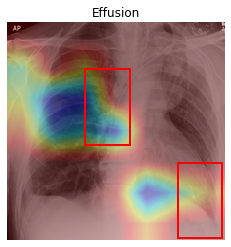

In [355]:
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
# ======== Create heatmap ===========
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[1]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    logit = best_net(input_img)
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
print('{:.4f} -> {}'.format(probs[0], classes[idx[0].item()]))

grad_cam = GradCAM(net=best_net, layer_name='dense_net_121.features.denseblock4.denselayer16.conv2')
data = grad_cam(input_img)  # cam mask
grad_cam.remove_handlers()
# Find local maxima
neighborhood_size = 100
threshold = .1
    
data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
for _ in range(5):
    maxima = binary_dilation(maxima)
    
labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

heat_map = cv2.applyColorMap(np.uint8(255 * data), cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))

        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
       
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes

plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

0.0873 -> Effusion


(-0.5, 223.5, 223.5, -0.5)

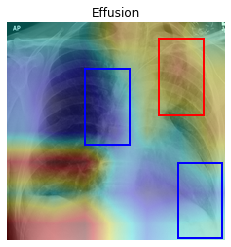

In [361]:
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import scipy.ndimage as ndimage
# ======== Create heatmap ===========
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[1]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    logit = best_net(input_img)
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
print('{:.4f} -> {}'.format(probs[0], classes[idx[0].item()]))

grad_cam_plus_plus = GradCamPlusPlus(net=best_net, layer_name='dense_net_121.features.denseblock4.denselayer16.conv2')
data = grad_cam_plus_plus(input_img)  # cam mask
grad_cam_plus_plus.remove_handlers()
# Find local maxima
neighborhood_size = 100
threshold = .1
    
data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
for _ in range(5):
    maxima = binary_dilation(maxima)
    
labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

heat_map = cv2.applyColorMap(np.uint8(255 * data), cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
rect = patches.Rectangle((x, y), w, h,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))

        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
       
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='b', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes

plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

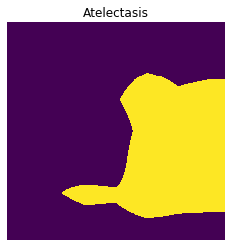

In [420]:
# Grayscale then Otsu's threshold
#gray = cv2.cvtColor(cam_img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(cam_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#for c in cnts:
#    x,y,w,h = cv2.boundingRect(c)
#    cv2.rectangle(thresh, (x, y), (x + w, y + h), (36,255,12), 2)

plt.imshow(thresh)
plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

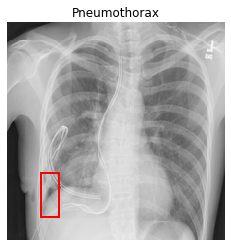

In [651]:
bidx = 890
raw_img = Image.open(os.path.join(img_path, bbN[bidx])).convert('RGB')
width, height = raw_img.size   # Get dimensions
x_scale = 256/width
y_scale = 256/height
raw_img = raw_img.resize((256, 256),Image.ANTIALIAS)
width, height = raw_img.size   # Get dimensions
left = (width - 224)/2
top = (height - 224)/2
right = (width + 224)/2
bottom = (height + 224)/2
crop_del = (256-224)/2
raw_img = raw_img.crop((left, top, right, bottom)) 
raw_img= np.array(raw_img)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(raw_img)
x, y, w, h = int(bBox[bidx][0])*x_scale-crop_del, int(bBox[bidx][1])*y_scale-crop_del, int(bBox[bidx][2])*x_scale, int(bBox[bidx][3])*y_scale
rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes

img_label = np.array(CLASS_NAMES_Box)[np.where(bbY[bidx]==1)[0]]
plt.title(img_label[0]) #show labels
plt.axis('off')

0.0774 -> Mass
0.0761 -> Nodule
0.0758 -> Infiltration
0.0731 -> Pneumothorax
0.0718 -> Emphysema
0.0715 -> Effusion
0.0715 -> Pleural_Thickening
0.0705 -> Atelectasis
0.0700 -> Fibrosis
0.0696 -> Consolidation
0.0685 -> Pneumonia
0.0683 -> Edema
0.0681 -> Cardiomegaly
0.0678 -> Hernia


(-0.5, 223.5, 223.5, -0.5)

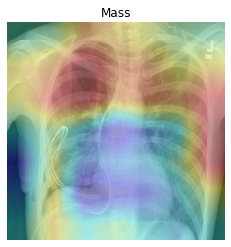

In [652]:
network_model = best_net.dense_net_121.features
network_model.eval()  # set network as evaluation model
best_net.eval()
with torch.autograd.no_grad():
    input_img = torch.from_numpy(bbI[bidx]).type(torch.FloatTensor).cuda()
    input_img = input_img.unsqueeze_(0)
    var_output = network_model(input_img)#forword
    logit = best_net(input_img)#forword
    h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
    probs, idx = h_x.sort(0, True) #probabilities of classe
        
cls_weights = list(best_net.parameters())
weight_softmax = np.squeeze(cls_weights[-2].data.cpu().numpy()) 
classes = {0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Effusion', 3: 'Infiltration', 4:'Mass', 5:'Nodule', 6:'Pneumonia',\
           7:'Pneumothorax',8:'Consolidation',9:'Edema',10:'Emphysema',11:'Fibrosis',12:'Pleural_Thickening',13:'Hernia'}
# output: the prediction
for i in range(0, N_CLASSES):
    line = '{:.4f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
    
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape

    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
    #cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img
#get the class activation maps
cam_img = returnCAM(var_output.cpu().data.numpy(), weight_softmax, idx[0].item())
heat_map = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
plt.imshow(output_img)
plt.title(classes[idx[0].item()]) #show labels
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

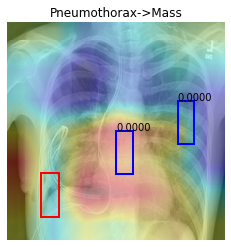

In [653]:
data = cam_img
data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
#for _ in range(5):
#    maxima = binary_dilation(maxima)
    
labeled, num_objects = ndimage.label(maxima)
#slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

#avg_size = np.array([[411.8, 512.5, 219.0, 139.1], [348.5, 392.3, 479.8, 381.1],
#                     [396.5, 415.8, 221.6, 318.0], [394.5, 389.1, 294.0, 297.4],
#                     [434.3, 366.7, 168.7, 189.8], [502.4, 458.7, 71.9, 70.4],
#                     [378.7, 416.7, 276.5, 304.5], [369.3, 209.4, 198.9, 246.0]])
#w_p, h_p = (avg_size[idx[0].item()][2:4] * (256 / 1024)).astype(np.int)


def IOU(xywh1, xywh2):#metric
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return (intersection / union)

heat_map = cv2.applyColorMap(np.uint8(255 * data), cv2.COLORMAP_JET)
output_img = cv2.addWeighted(np.array(raw_img),0.7,heat_map,0.3,0)
#plotting bounding box
fig,ax = plt.subplots(1)# Create figure and axes
ax.imshow(output_img)
rect = patches.Rectangle((x, y), w, h,linewidth=2, edgecolor='r', facecolor='none')# Create a Rectangle patch
ax.add_patch(rect)# Add the patch to the Axes
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        x_p = int(max(pt[0], 0.))
        y_p = int(max(pt[1], 0.))
        w_p = int(min(x_p + w, 224)) - x_p
        h_p = int(min(y_p + h, 224)) - y_p
        
        IoU_score = IOU([x,y,w,h],[x_p,y_p,w_p,h_p])
        #print('IoU_score = {:.4f}'.format(IoU_score))
        rect = patches.Rectangle((x_p, y_p), w_p, h_p,linewidth=2, edgecolor='b', facecolor='none')# Create a Rectangle patch
        ax.add_patch(rect)# Add the patch to the Axes
        ax.text(x_p, y_p, '{:.4f}'.format(IoU_score))

plt.title(img_label[0] + '->' + classes[idx[0].item()]) #show labels
#plt.title('Infiltration' + '->' + classes[idx[1].item()]) #show labels

plt.axis('off')